<a href="https://colab.research.google.com/github/VihangVaidya/Steinmetz-code-Bichak-Pod/blob/main/Vihang_Steinmetz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import seaborn as sns
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
rng = 69
np.set_printoptions(threshold=sys.maxsize)

Mounted at /content/drive


In [2]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

# Playground


In [4]:
session_ids_with_ACA = []
for session_id, session in enumerate(alldat):
  if np.isin(np.unique(session['brain_area']),'ACA').any():
    session_ids_with_ACA.append(session_id)

sessions_with_ACA = alldat[session_ids_with_ACA]


In [5]:
for idx, session in enumerate(sessions_with_ACA):
  session['ACA_neurons'] = session['spks'][session['brain_area']=='ACA']
  session['ACA_neuron_locations'] = session['ccf'][session['brain_area']=='ACA']


In [6]:
#@title Go_NoGo_filter function {form-width: "10%"}
def Go_NoGo_filter(session, gonogo=None, response=None):
  """filters out only NoGo trials from a session, with additional paramters

  Args:
    session (dict): any of the 39 sessions.
    gonogo (str): input "go" and "nogo" to filter the respective trials
    response (string): Optional Argument. input "correct" or "wrong" in this paramater to get only those sessions
  Returns:
    filter (boolean array): a boolean array in which True corresponds to indexes which met the condition
  """

  nogo_filter = (session['contrast_left'] == 0) & (session['contrast_right'] == 0)
  go_filter = ~nogo_filter
  nogo_correct_filter = nogo_filter & (session['response'] == 0)
  nogo_wrong_filter = nogo_filter & (session['response'] != 0)
  go_correct_filter = go_filter & (session['feedback_type'] == 1)
  go_missed_filter = go_filter & (session['response'] == 0)
  go_wrong_filter = go_filter & (~go_correct_filter) & (~go_missed_filter)
  go_wrong_missed_filter = go_filter & (go_wrong_filter | go_missed_filter)

  if gonogo is None:
    if response=="correct":
      filter = session['feedback_type']==1
    elif response == "wrong":
      filter = (session['feedback_type']==-1) & (session['response']!=0)
    elif response == "missed":
      filter = go_missed_filter
    elif response == "wrong&missed":
      filter = session['feedback_type']==-1
    elif response is None:
      filter = np.repeat(True, session['spks'].shape[1])
    else:
      raise ValueError("incorrect paramters")
  elif gonogo=="go":
    if response=="correct":
      filter = go_correct_filter
    elif response == "wrong":
      filter = go_wrong_filter
    elif response == "missed":
      filter = go_missed_filter
    elif response =="wrong&missed":
      filter = go_wrong_missed_filter
    elif response is None:
      filter = go_filter
    else:
      raise ValueError("incorrect parameters")
  elif gonogo=="nogo":
    if response=="correct":
      filter = nogo_correct_filter
    elif response == "wrong":
      filter = nogo_wrong_filter
    elif response is None:
      filter = nogo_filter
    else:
      raise ValueError("incorrect parameters")      
  else:
    raise ValueError("invalid paramter for gonogo argument")
  return filter







In [7]:
filters = []
for idx, session in enumerate(sessions_with_ACA):
  filters.append(Go_NoGo_filter(session, "nogo"))


# Raster Plot section

In [8]:
def make_raster(neuron_data, min=0, max=1, map="Blues", title=None, xlabel="time bins", ylabel="Neuron Number"):
  """makes a raster plot for neuronal spiking data and prints it

  Args:
  neuron_data (2D numpy array): neuronal spiking data. neuron ID by time bins
  min (float/int): minimum value for colorcoding in heatmap. default is 0
  max (float/int): maximum value for colorcoding in heatmap. default is 1
  map (str): cmap type for the heatmap. default is "hot"
  title (str): title of plot. default is None
  xlabel (str): label of x-axis
  ylabel (str): label of y-axis

  Returns:
  Nothing
  """
  pl1 = sns.heatmap(neuron_data, vmin=min, vmax=max, cmap=map)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show(pl1)

In [9]:
def filter_plot(session, idx = None, gonogo=None, response=None, mean=True):
  ACA_neurons = session['ACA_neurons']
  filter = Go_NoGo_filter(session, gonogo=gonogo, response=response)
  neurons = ACA_neurons[:,filter,:]
  no_of_trials = neurons.shape[1]
  if mean:
    n = -1
  else:
    try:
      n = input(f"There are {no_of_trials} trials in the session. Enter trial number (from 0 to {no_of_trials - 1}): ").strip().lower()
      n = int(n)
      if not 0<=n<no_of_trials:
        sys,exit(f"Invalid Input! Enter an integer between 0 and {no_of_trials - 1} only. Rerun the cell with correct input")
    except TypeError:
      sys.exit("Error! Invalid input. Enter an integer. Rerun the cell with correct input")
  if gonogo is None:
    gonogo = ''
  if idx is None:
    idx = ''
  if response is None:
    response = "all"
  if n == -1:
    graph_input = np.mean(neurons, axis=1)
    make_raster(graph_input, title = f"Average {gonogo} heatmap for session {idx} containing {no_of_trials} trials & {neurons.shape[0]} neurons, and {response} responses")
  else:
    graph_input = neurons[:, n, :]
    make_raster(graph_input, title = f"Raster for trial {n} from session {idx} containing {no_of_trials} trials & {neurons.shape[0]} neurons, and {response} responses")

  
  

  










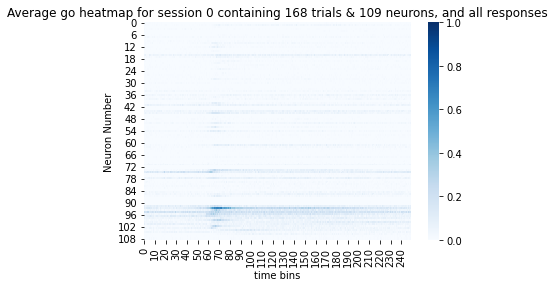

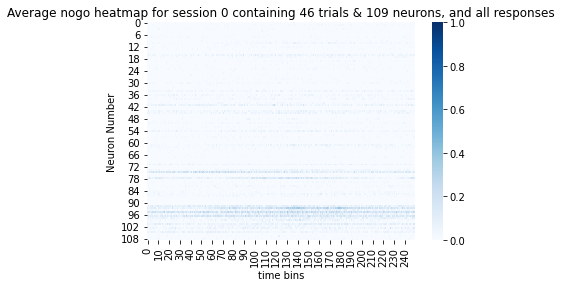

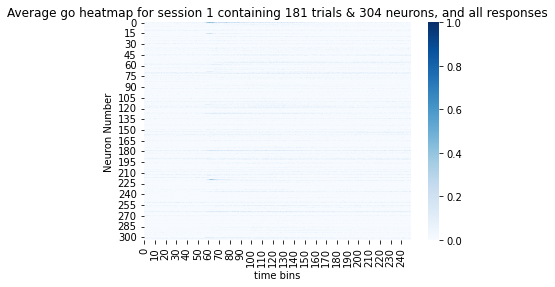

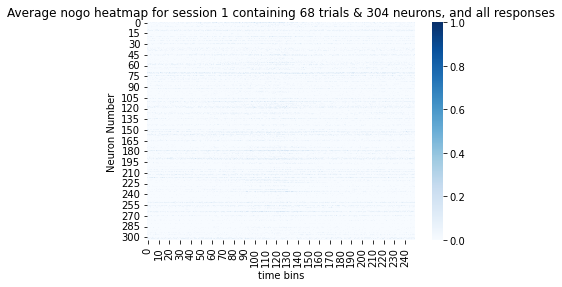

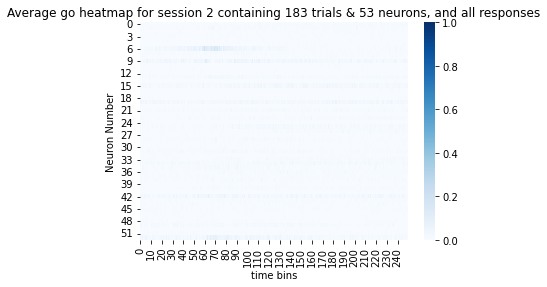

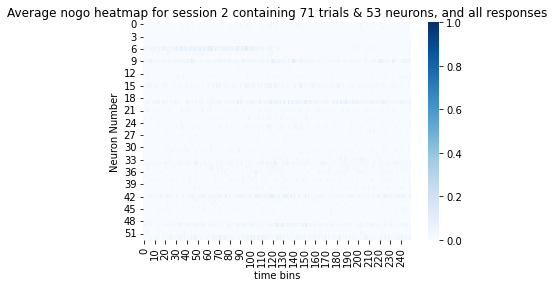

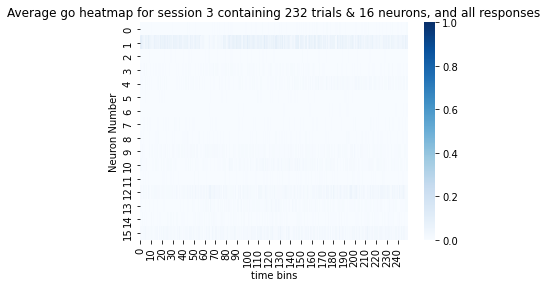

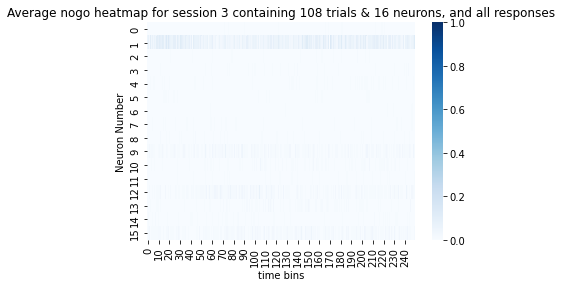

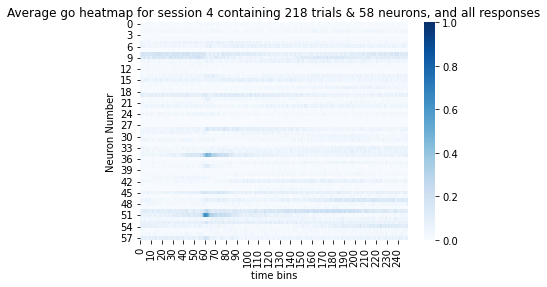

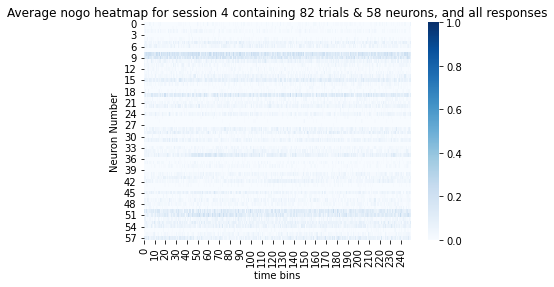

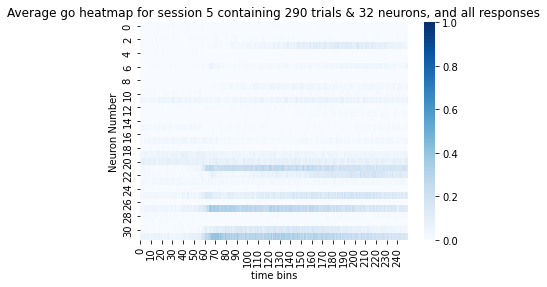

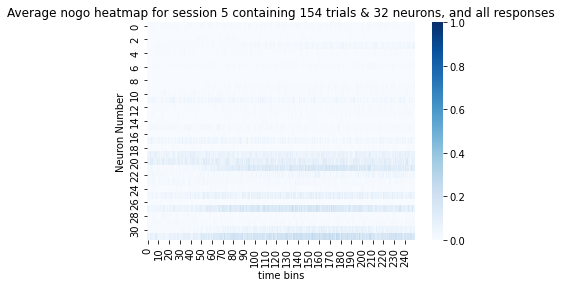

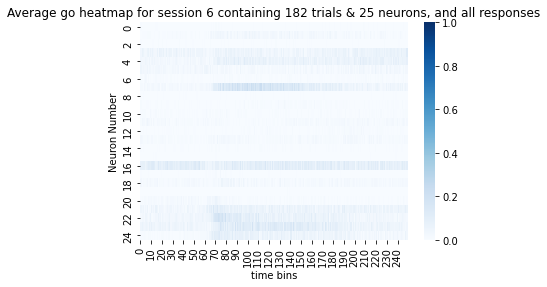

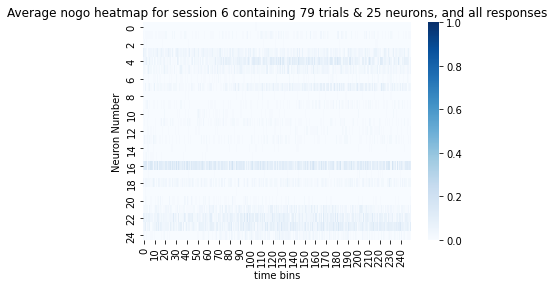

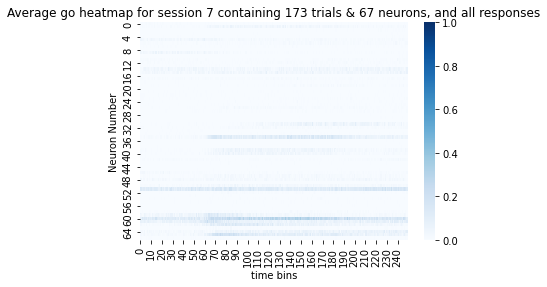

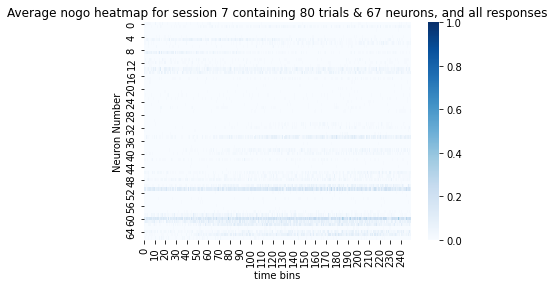

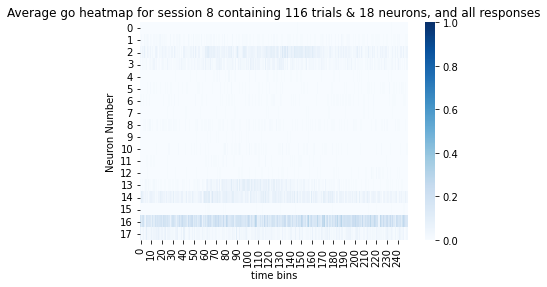

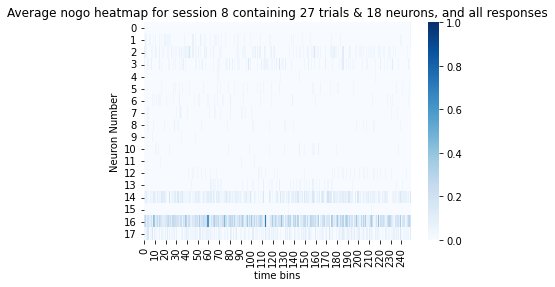

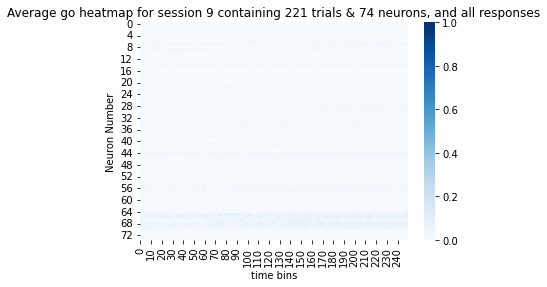

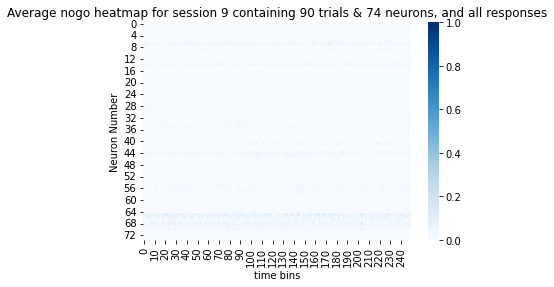

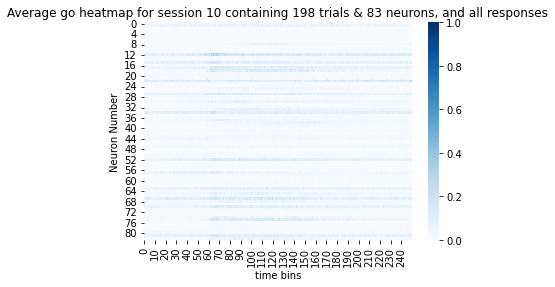

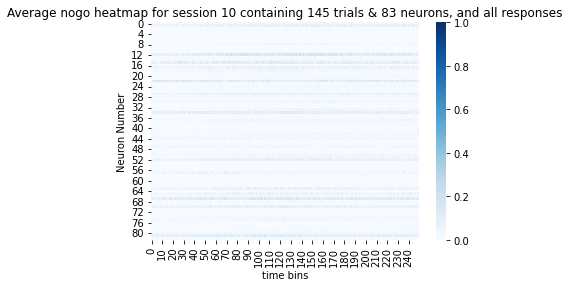

In [10]:
for idx, session in enumerate(sessions_with_ACA):
  filter_plot(session, idx, "go", mean=True)
  filter_plot(session, idx, "nogo", mean=True)

  

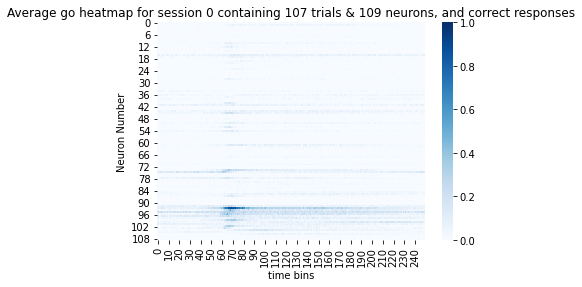

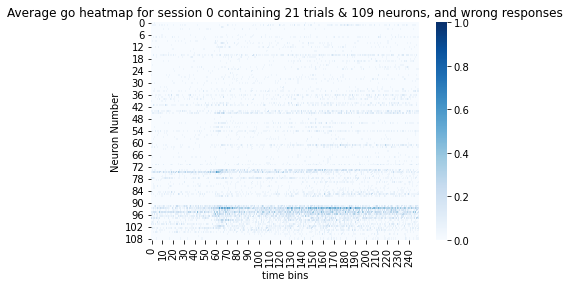

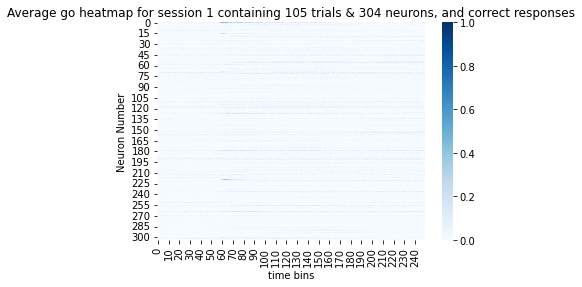

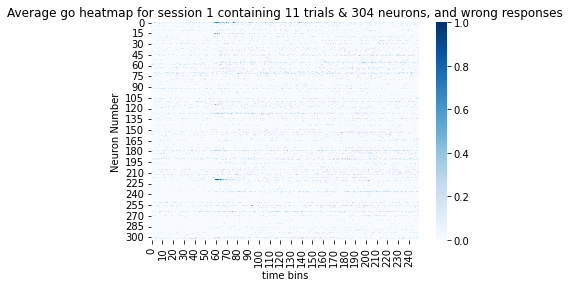

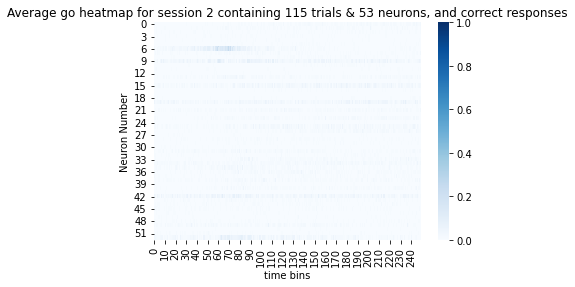

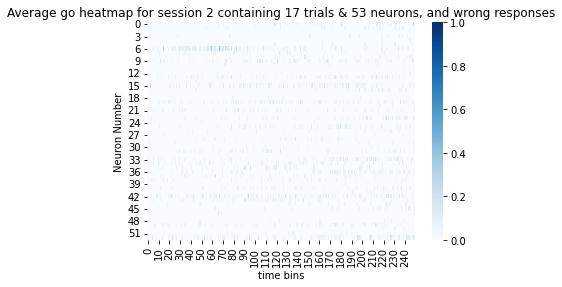

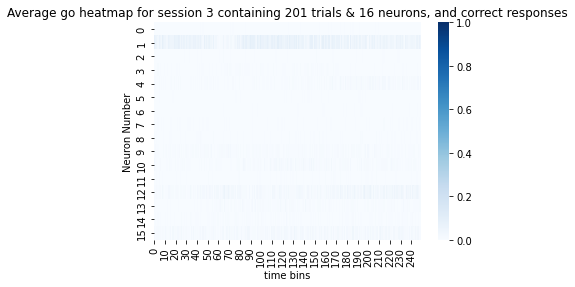

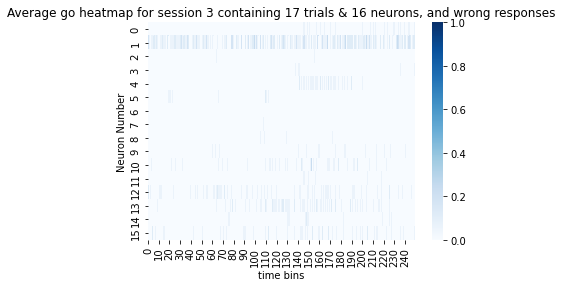

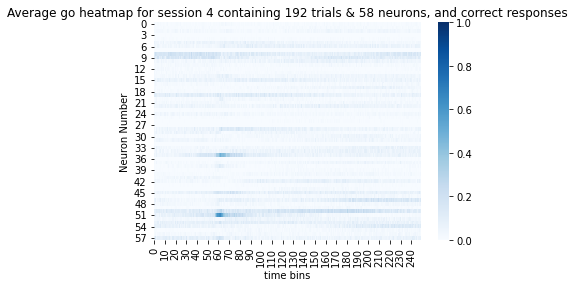

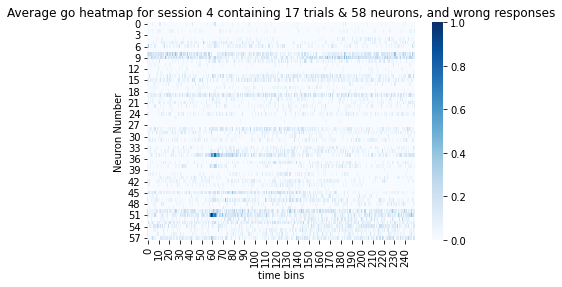

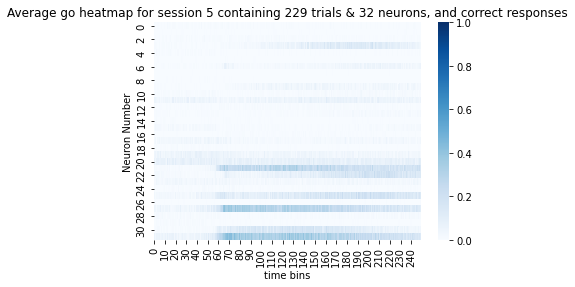

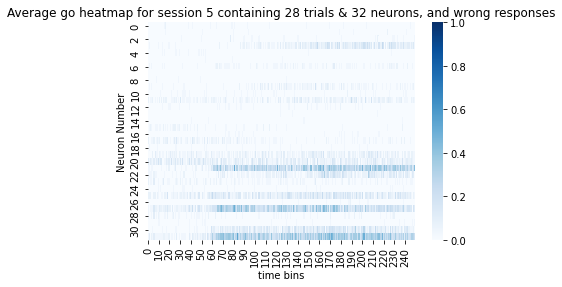

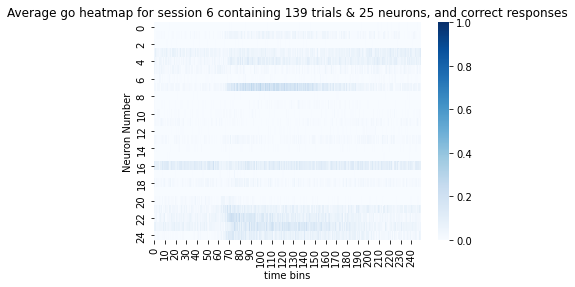

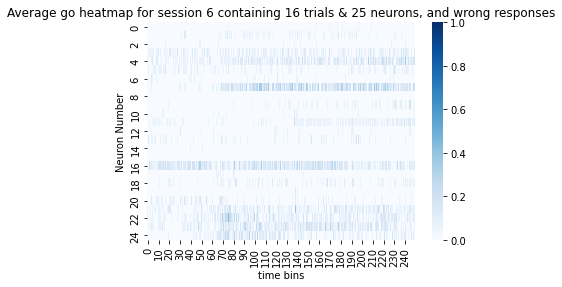

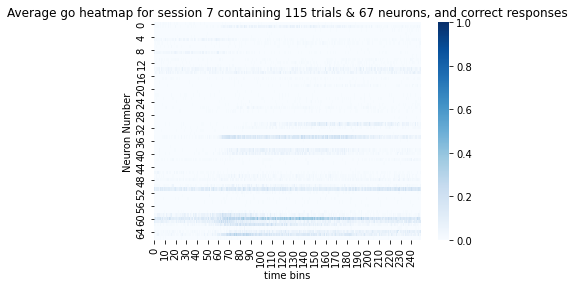

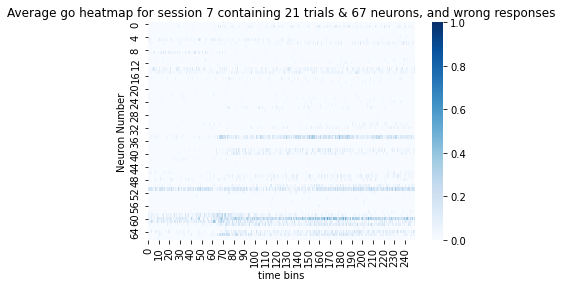

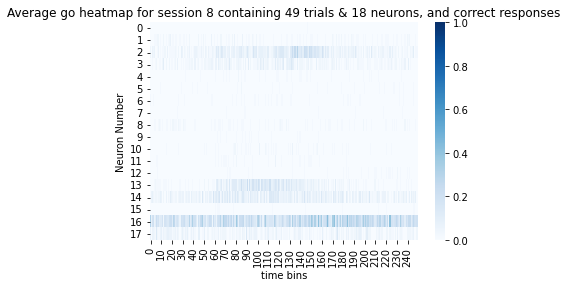

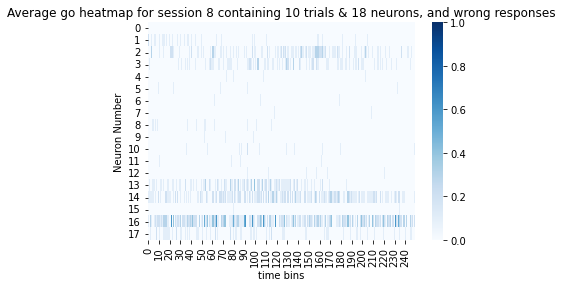

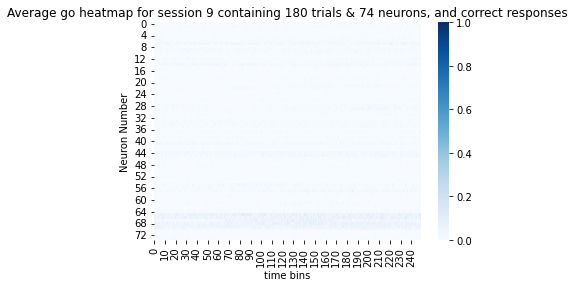

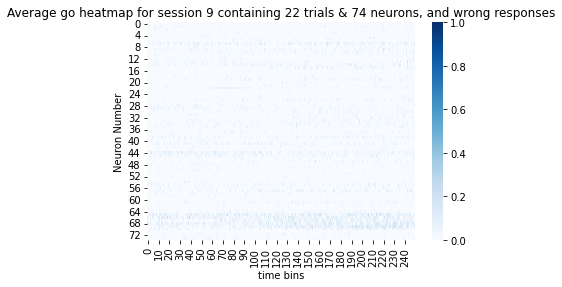

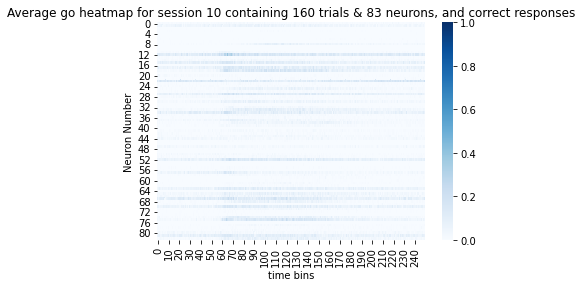

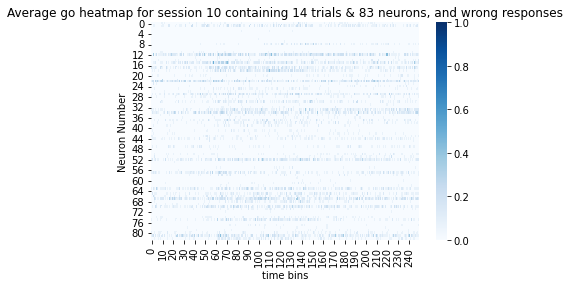

In [11]:
for idx, session in enumerate(sessions_with_ACA):
  filter_plot(session, idx, "go", "correct", mean=True)
  filter_plot(session, idx, "go", "wrong", mean=True)
  

# Difference in Stimulus Section (incomplete)


In [12]:
a = np.array([-1., 0., 1.])
b = np.array([-1., -1., -1.])

e = (a==0) & (b==-1)
print(e)


[False  True False]


In [13]:
for sesssion in sessions_with_ACA:
  session['contrast_left'][session['contrast_left']==1] = 0.75
  session['contrast_right'][session['contrast_right']==1]=0.75
  session['diff_stim'] = session['contrast_right'] - session['contrast_left'] #added a new key to each session containing difference in stimulus

def plot_spike_rate(spike_data, title=None, label=None, ):
  dt = 0.01  # binning at 10 ms
  NT = 250
  time_bins = dt * np.arange(NT)
  plt.title(title)
  plt.plot(time_bins, spike_data,label=label)
  plt.show()

for idx, session in enumerate(sessions_with_ACA):
  ACA_neurons = session['spks'][session['brain_area']=='ACA']


  



# Finding Common Neurons

In [14]:
for idx,session in enumerate(sessions_with_ACA):
  ACA_neuron_locations = session['ACA_neuron_locations']
  print(f"\nsession {idx}:")
  print(ACA_neuron_locations)



session 0:
[[4090.  2445.4 5012.4]
 [4172.1 2979.3 5018.3]
 [4069.2 2267.4 5063.3]
 [4092.9 2425.6 5060.4]
 [4042.5 2129.  5018.2]
 [4036.6 2089.4 5019. ]
 [4112.7 2583.8 5025.7]
 [4117.7 2603.6 5041.2]
 [4110.7 2544.3 5058.2]
 [4122.6 2623.4 5056.7]
 [4063.2 2227.9 5064. ]
 [4135.5 2722.2 5039. ]
 [4098.8 2465.2 5059.6]
 [4116.6 2583.8 5057.4]
 [4076.1 2326.7 5046.3]
 [4135.5 2722.2 5039. ]
 [4141.4 2761.8 5038.2]
 [4084.  2405.8 5013.1]
 [4095.9 2484.9 5011.6]
 [4076.1 2326.7 5046.3]
 [4054.4 2208.1 5016.8]
 [4111.7 2564.  5041.9]
 [4082.  2366.3 5045.6]
 [4084.  2405.8 5013.1]
 [4083.  2386.1 5029.3]
 [4090.  2445.4 5012.4]
 [4095.9 2484.9 5011.6]
 [4092.9 2425.6 5060.4]
 [4036.6 2089.4 5019. ]
 [4092.9 2425.6 5060.4]
 [4136.5 2742.  5022.7]
 [4082.  2366.3 5045.6]
 [4099.8 2484.9 5043.4]
 [4107.8 2564.  5010.2]
 [4084.  2405.8 5013.1]
 [4095.9 2484.9 5011.6]
 [4066.2 2287.2 5015.3]
 [4131.5 2722.2 5007.2]
 [4106.8 2544.3 5026.4]
 [4042.5 2129.  5018.2]
 [4063.2 2227.9 5064. ]
 [41

# PCA


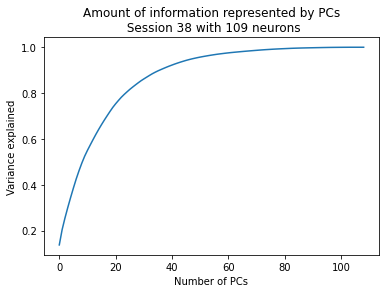

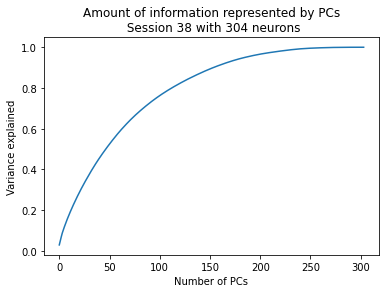

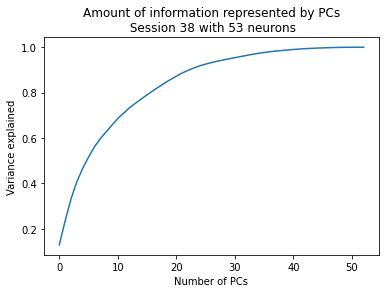

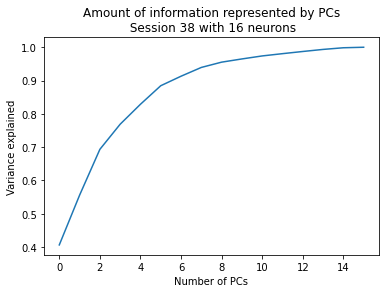

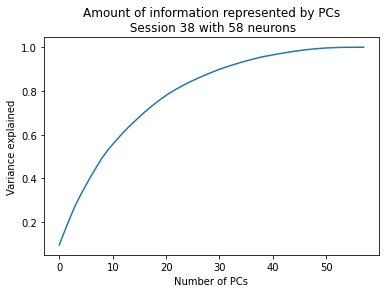

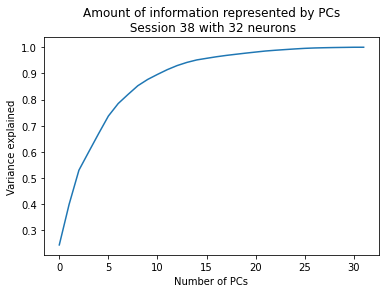

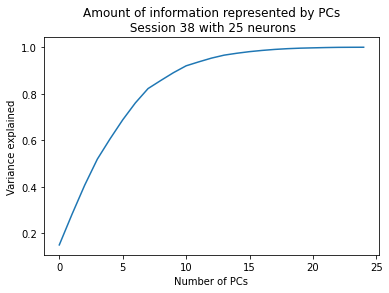

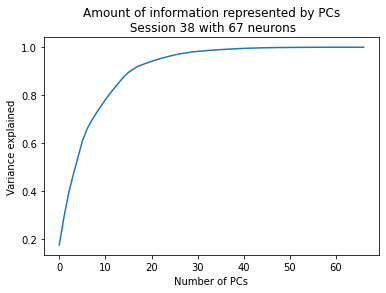

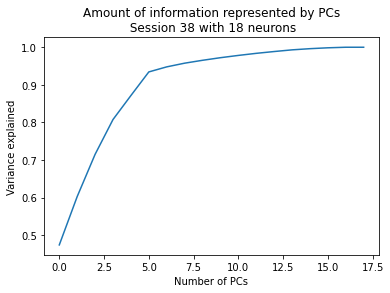

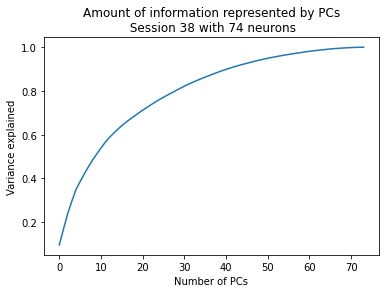

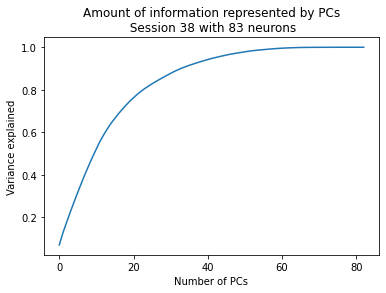

In [15]:
for idx, session in enumerate(sessions_with_ACA):
  

  aca_area = (session['brain_area'] == 'ACA')
  aca_spikes = session['spks'][aca_area]
  NN = aca_spikes.shape[0]
  number_of_components = NN
  NT = 250
  droll = np.reshape(aca_spikes[:, :, 51:130], (NN, -1))  # first 80 bins = 1.6 sec
  droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
  pca_model = PCA(n_components=number_of_components).fit(droll.T)
  W = pca_model.components_
  pc_10ms = W @ np.reshape(aca_spikes, (NN, -1))
  pc_10ms = np.reshape(pc_10ms, (number_of_components, -1, NT))

  plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
  plt.title(f'Amount of information represented by PCs\n Session {session_id} with {NN} neurons')
  plt.xlabel('Number of PCs')
  plt.ylabel('Variance explained')
  plt.show()

In [16]:
#Aim: to make Desgin matrix for PCA for each valid session (6 out of 11)
sessions_for_PCA = []
for idx, session in enumerate(sessions_with_ACA): #looping across all sessions with ACA in them
  if idx == 1:
    continue #removing the session 1 as its variance cannot be explained by 50 PCs
  if session['ACA_neurons'].shape[0]>50: 
    sessions_for_PCA.append(session) #adding only those sessions which have more than 50 neurons
all_reshaped_matrices = []
all_centered_matrices = []
for idx, session in enumerate(sessions_for_PCA):
  
  reshaped_matrix=np.zeros((session['ACA_neurons'].shape[0], session['ACA_neurons'].shape[1]*session['ACA_neurons'].shape[2]))
  for i, neuron in enumerate(session['ACA_neurons']):
    reshaped_matrix[i, :] = (np.reshape(neuron, neuron.shape[0]*neuron.shape[1])) #concatenating all the trials for one neuron together to reduce dimensions from 3 to 2 (Rishabh)
  reshaped_matrix = reshaped_matrix.T #making a transverse
  centered_matrix = StandardScaler().fit_transform(reshaped_matrix)
  all_centered_matrices.append(centered_matrix) #adding all 6 design matrices to 1 big mega-matrix for easy access
  all_reshaped_matrices.append(reshaped_matrix)

#Aim: to use the desgin matrix for each session and make a model for each valid session (6 out of 11)
all_reduced_matrices = []
v = []
for idx, matrix in enumerate(all_centered_matrices):
  model = PCA(n_components=50, random_state=rng).fit(matrix)
  reduced_matrix = model.transform(matrix)
  print(model.explained_variance_ratio_.sum())
  all_reduced_matrices.append(reduced_matrix)




  

  
def matrix_reshaper(input_matrix, NT):
  input_matrix = input_matrix.T
  columns = input_matrix.shape[1]
  number_of_trials = int(columns/NT)
  arr = np.arange(0, columns, NT, dtype=int)
  output_matrix = np.zeros((number_of_trials, input_matrix.shape[0], NT))
  for i, n in enumerate(arr):
    for j in range(input_matrix.shape[0]):
      for k in range(NT):
        output_matrix[i, j, k] = input_matrix[j,n+k]
  return output_matrix #trials x 50 features x 250 time bins


original_shape_matrices = []
for idx, matrix in enumerate(all_reduced_matrices):
  output_matrix = matrix_reshaper(matrix, sessions_for_PCA[idx]['ACA_neurons'].shape[2])
  original_shape_matrices.append(output_matrix)
  print(output_matrix.shape)







    




  

  
  

 
  


  
  



0.4939891121467952
0.9654993917172502
0.8809941091751138
0.7800885426358036
0.6884622779708776
0.6625432626790789
(214, 50, 250)
(254, 50, 250)
(300, 50, 250)
(253, 50, 250)
(311, 50, 250)
(343, 50, 250)


# Testing PCA + combined session SVM on different classifications

In [17]:
#@title creating SVM function
def make_SVM(X,y, classification_list, rng=None, kernel="rbf", cv=8):
  

  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=rng)
  svm = SVC(kernel=kernel, random_state=rng).fit(X_train, y_train)
  y_pred = svm.predict(X_train)
  train_score = (y_pred==y_train).astype(int).mean()
  cv_score = cross_val_score(svm, X_train, y_train, cv=cv).mean()
  test = svm.predict(X_test)
  test_score = (test==y_test).astype(int).mean()
  return train_score, cv_score, test_score


In [18]:
#@title function to stack all trials to flatten the matrix {form-width:"10%"}
def create_5():
  y_combined = np.array([])
  X = np.zeros((1,50))

  for idx, session in enumerate(sessions_for_PCA):
    go_correct_filter = Go_NoGo_filter(session, "go", "correct")
    go_wrong_filter = Go_NoGo_filter(session, "go", "wrong")
    go_missed_filter = Go_NoGo_filter(session, "go", "missed")
    nogo_correct_filter = Go_NoGo_filter(session, "nogo", "correct")
    nogo_wrong_filter = Go_NoGo_filter(session, "nogo", "wrong")

    #create a 1-D array containing strings
    y = np.empty(session['spks'].shape[1], dtype=object)
    y[go_correct_filter] = "Go: Correct"
    y[go_wrong_filter] = "Go: Wrong"
    y[go_missed_filter] = "Go: Missed"
    y[nogo_correct_filter] = "NoGo: Correct"
    y[nogo_wrong_filter] = "NoGo: Wrong"
    y_combined = np.concatenate((y_combined, y))
  y = y_combined
  
  for idx, matrix in enumerate(original_shape_matrices):
    two_d = np.var(matrix, axis=2)
    
    X = np.vstack((X, two_d))
  X = X[1:, :]
  classification_list = ["Go: Correct", "Go: Wrong", "Go: Missed", "NoGo: Correct", "NoGo: Wrong"]
  return (X, y, classification_list)




  







In [19]:
rbf_list = []
poly_list = []
sigmoid_list = []
#@title Go vs NoGo {form-width:"10%"}
y1 = np.array([])
X, y, _ = create_5()
X1=X
for session in sessions_for_PCA:
  go_filter = Go_NoGo_filter(session, "go")
  nogo_filter = Go_NoGo_filter(session, "nogo")
  y_sesh = np.empty(session['spks'].shape[1], dtype=object)
  classification_list = ["Go", "NoGo"]
  y_sesh[go_filter] = classification_list[0]
  y_sesh[nogo_filter] = classification_list[1]
  y1 = np.concatenate((y1, y_sesh))
iter = 10
cv=8
print(f"SVM Model Details-\nGo vs NoGo\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")

g31 = []
g331 = []
g3331 = []
kernel_list = ["rbf", "poly", "sigmoid"]
for kernel in kernel_list:
  train_score=[]
  cv_score=[]
  test_score=[]
  for i in range(iter):
    a,b,c = make_SVM(X1,y1, classification_list, rng=i, kernel=kernel, cv=cv)
    train_score.append(a)
    cv_score.append(b)
    test_score.append(c)

  avg_train_score = np.array(train_score).mean() * 100
  avg_cv_score = np.array(cv_score).mean() *100
  avg_test_score = np.array(test_score).mean()*100
  if kernel=="rbf":
    rbf_list.append(avg_cv_score)
    g31 = cv_score
    g331 = train_score
    g3331 = test_score
  elif kernel=="poly":
    poly_list.append(avg_cv_score)
  else:
    sigmoid_list.append(avg_cv_score)

  print(f"kernel: {kernel}")
  print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")
print(g31)

SVM Model Details-
Go vs NoGo
number of iterations: 10
8-fold Cross Validation

kernel: rbf
Average Score on Train data: 70.93%
Average Score on Test data: 69.93%
Average Cross-Validation Score: 69.32%


kernel: poly
Average Score on Train data: 71.72%
Average Score on Test data: 69.33%
Average Cross-Validation Score: 68.68%


kernel: sigmoid
Average Score on Train data: 68.16%
Average Score on Test data: 67.49%
Average Cross-Validation Score: 67.47%


[0.6831210191082802, 0.6823248407643312, 0.7062101910828025, 0.6839171974522293, 0.697452229299363, 0.7014331210191083, 0.7030254777070064, 0.6855095541401273, 0.6950636942675159, 0.6934713375796178]


In [20]:
#@title Go: Wrong vs Go: Correct vs Go: Missed {form-width:"10%"}
X,y, _ = create_5()
boo = []
for element in y:
  boo.append(element.startswith("Go"))
y2 = y[boo]
X2 = X[boo, :]
classification_list=["Go: Wrong", "Go: Correct", "Go: Missed"]

iter = 10
cv=8
print(f"SVM Model Details-\nGo: Wrong vs Go: Correct vs Go: Missed\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")

g32 = []
kernel_list = ["rbf", "poly", "sigmoid"]
for kernel in kernel_list:
  train_score=[]
  cv_score=[]
  test_score=[]
  for i in range(iter):
    a,b,c = make_SVM(X2,y2, classification_list, rng=i, kernel=kernel, cv=cv)
    train_score.append(a)
    cv_score.append(b)
    test_score.append(c)

  avg_train_score = np.array(train_score).mean() * 100
  avg_cv_score = np.array(cv_score).mean() *100
  avg_test_score = np.array(test_score).mean()*100
  if kernel=="rbf":
    rbf_list.append(avg_cv_score)
    g32 = cv_score
  elif kernel=="poly":
    poly_list.append(avg_cv_score)
  else:
    sigmoid_list.append(avg_cv_score)

  print(f"kernel: {kernel}")
  print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")
print(g32)

SVM Model Details-
Go: Wrong vs Go: Correct vs Go: Missed
number of iterations: 10
8-fold Cross Validation

kernel: rbf
Average Score on Train data: 76.74%
Average Score on Test data: 75.81%
Average Cross-Validation Score: 74.78%


kernel: poly
Average Score on Train data: 78.89%
Average Score on Test data: 74.98%
Average Cross-Validation Score: 74.54%


kernel: sigmoid
Average Score on Train data: 74.39%
Average Score on Test data: 74.85%
Average Cross-Validation Score: 74.51%


[0.7436714237172953, 0.7448394495412844, 0.7413778457356439, 0.7574966021066938, 0.7586327726809378, 0.7448394495412844, 0.7287419300033979, 0.7551711688752973, 0.7482798165137614, 0.7551924057084607]


In [21]:
#@title NoGo: Correct vs NoGo: Wrong {form-width:"10%"}

X,y, _ = create_5()
boo = []
for element in y:
  boo.append(element.startswith("NoGo"))
y3 = y[boo]
X3 = X[boo, :]
classification_list = ["NoGo: Correct", "NoGo: Wrong"]
iter = 10
cv=8
print(f"SVM Model Details-\nNoGo: Correct vs NoGo: Wrong\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")

g33 = []
g333=[]
g3333=[]
kernel_list = ["rbf", "poly", "sigmoid"]
for kernel in kernel_list:
  train_score=[]
  cv_score=[]
  test_score=[]
  for i in range(iter):
    a,b,c = make_SVM(X3,y3, classification_list, rng=i, kernel=kernel, cv=cv)
    train_score.append(a)
    cv_score.append(b)
    test_score.append(c)

  avg_train_score = np.array(train_score).mean() * 100
  avg_cv_score = np.array(cv_score).mean() *100
  avg_test_score = np.array(test_score).mean()*100
  if kernel=="rbf":
    rbf_list.append(avg_cv_score)
    g33 = cv_score
    g333 = train_score
    g3333 = test_score
  elif kernel=="poly":
    poly_list.append(avg_cv_score)
  else:
    sigmoid_list.append(avg_cv_score)

  print(f"kernel: {kernel}")
  print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")

print(g33)

SVM Model Details-
NoGo: Correct vs NoGo: Wrong
number of iterations: 10
8-fold Cross Validation

kernel: rbf
Average Score on Train data: 66.73%
Average Score on Test data: 61.86%
Average Cross-Validation Score: 62.75%


kernel: poly
Average Score on Train data: 67.30%
Average Score on Test data: 61.47%
Average Cross-Validation Score: 61.95%


kernel: sigmoid
Average Score on Train data: 63.56%
Average Score on Test data: 62.25%
Average Cross-Validation Score: 62.21%


[0.6259566326530612, 0.6078337585034013, 0.6337159863945578, 0.6103847789115646, 0.6571534863945578, 0.6260097789115646, 0.6337691326530612, 0.6441326530612246, 0.6000212585034014, 0.636373299319728]


In [22]:

#@title Go: Response Given vs Go: Missed {form-width:"10%"}
X,y, _ = create_5()
boo = []
for element in y:
  boo.append(element.startswith("Go"))
y4= y[boo]
X4 = X[boo, :]
classification_list=["Go: Response Given", "Go: Missed"]

cv=8
iter = 10
print(f"SVM Model Details-\nGo: Response Given vs Go: Missed\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")

g34 = []

kernel_list = ["rbf", "poly", "sigmoid"]
for kernel in kernel_list:
  train_score=[]
  cv_score=[]
  test_score=[]
  for i in range(iter):
    a,b,c = make_SVM(X4,y4, classification_list, rng=i, kernel=kernel, cv=cv)
    train_score.append(a)
    cv_score.append(b)
    test_score.append(c)

  avg_train_score = np.array(train_score).mean() * 100
  avg_cv_score = np.array(cv_score).mean() *100
  avg_test_score = np.array(test_score).mean()*100
  if kernel=="rbf":
    rbf_list.append(avg_cv_score)
    g34 = cv_score
  elif kernel=="poly":
    poly_list.append(avg_cv_score)
  else:
    sigmoid_list.append(avg_cv_score)

  print(f"kernel: {kernel}")
  print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")
print(g34)

SVM Model Details-
Go: Response Given vs Go: Missed
number of iterations: 10
8-fold Cross Validation

kernel: rbf
Average Score on Train data: 76.74%
Average Score on Test data: 75.81%
Average Cross-Validation Score: 74.78%


kernel: poly
Average Score on Train data: 78.89%
Average Score on Test data: 74.98%
Average Cross-Validation Score: 74.54%


kernel: sigmoid
Average Score on Train data: 74.39%
Average Score on Test data: 74.85%
Average Cross-Validation Score: 74.51%


[0.7436714237172953, 0.7448394495412844, 0.7413778457356439, 0.7574966021066938, 0.7586327726809378, 0.7448394495412844, 0.7287419300033979, 0.7551711688752973, 0.7482798165137614, 0.7551924057084607]


In [23]:
#@title Correct vs Wrong { form-width: "10%" }

X,y, _ = create_5()
yy =[]
boo=[]
for element in y:
  if element.endswith("Correct"):
    yy.append("Correct")
  elif element.endswith("Wrong"):
    yy.append("Wrong")
  else:
    yy.append(None)
for element in yy:
  boo.append(element is not None)

y5 = np.array(yy)[boo]
X5= X[boo, :]
classification_list=["Correct", "Wrong"]
iter = 10
cv=8
print(f"SVM Model Details-\nCorrect vs Wrong\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")

g35 = []
g335=[]
g3335=[]
kernel_list = ["rbf", "poly", "sigmoid"]
for kernel in kernel_list:
  train_score=[]
  cv_score=[]
  test_score=[]
  for i in range(iter):
    a,b,c = make_SVM(X5,y5, classification_list, rng=i, kernel=kernel, cv=cv)
    train_score.append(a)
    cv_score.append(b)
    test_score.append(c)

  avg_train_score = np.array(train_score).mean() * 100
  avg_cv_score = np.array(cv_score).mean() *100
  avg_test_score = np.array(test_score).mean()*100
  if kernel=="rbf":
    rbf_list.append(avg_cv_score)
    g35 = cv_score
    g335 = train_score
    g3335 = test_score
  elif kernel=="poly":
    poly_list.append(avg_cv_score)
  else:
    sigmoid_list.append(avg_cv_score)

  print(f"kernel: {kernel}")
  print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")

print(g35)

SVM Model Details-
Correct vs Wrong
number of iterations: 10
8-fold Cross Validation

kernel: rbf
Average Score on Train data: 80.50%
Average Score on Test data: 80.56%
Average Cross-Validation Score: 79.51%


kernel: poly
Average Score on Train data: 82.13%
Average Score on Test data: 79.60%
Average Cross-Validation Score: 78.62%


kernel: sigmoid
Average Score on Train data: 78.57%
Average Score on Test data: 79.65%
Average Cross-Validation Score: 78.58%


[0.8010701621073961, 0.793040780141844, 0.7992907801418441, 0.8001773049645391, 0.7841248733535968, 0.8001773049645391, 0.7912613981762917, 0.7867971124620061, 0.7957193515704154, 0.7992844478216818]


# Using SVM on individual sessions

In [24]:
g2_data_1=[]
#@title Go vs NoGo { form-width: "10%" }
iter = 10
cv=5
poly = []
rbf = []
sigmoid = []
print(f"SVM Model Details-\nGo vs NoGo\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")
for idx,session in enumerate(sessions_with_ACA):
  print(f"SESSION {idx} with {session['ACA_neurons'].shape[0]} neurons:\n")
  go_filter = Go_NoGo_filter(session, "go")
  nogo_filter = Go_NoGo_filter(session, "nogo")
  X =np.mean(session['ACA_neurons'], axis=2)
  X = X.T
  y = y = np.empty(session['ACA_neurons'].shape[1], dtype=object)
  y[go_filter] = "Go"
  y[nogo_filter] = "NoGo"
  classification_list = ["Go", "NoGo"]
  



  kernel_list = ["rbf", "poly", "sigmoid"]
  for kernel in kernel_list:
    train_score=[]
    cv_score=[]
    test_score=[]
    for i in range(iter):
      a,b,c = make_SVM(X,y, classification_list, rng=i, kernel=kernel, cv=cv)
      train_score.append(a)
      cv_score.append(b)
      test_score.append(c)
      if kernel=="rbf":
        g2_data_1.append(b)

    
    avg_train_score = np.array(train_score).mean()* 100
    avg_cv_score = np.array(cv_score).mean()* 100
    avg_test_score = np.array(test_score).mean() * 100
    if kernel=="rbf":
      rbf.append(avg_cv_score)
    elif kernel=="poly":
      poly.append(avg_cv_score)
    else:
       sigmoid.append(avg_cv_score)

    print(f"kernel: {kernel}")
    print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")
print(f"average cv score for poly: {np.array(poly).mean():.2f}%")
print(f"average cv score for rbf: {np.array(rbf).mean():.2f}%")
print(f"average cv score for sigmoid: {np.array(sigmoid).mean():.2f}%")
 
print(rbf)
rbf_list.append(np.array(rbf).mean())
poly_list.append(np.array(poly).mean())
sigmoid_list.append(np.array(sigmoid).mean())
print(rbf_list)

SVM Model Details-
Go vs NoGo
number of iterations: 10
5-fold Cross Validation

SESSION 0 with 109 neurons:

kernel: rbf
Average Score on Train data: 90.06%
Average Score on Test data: 89.81%
Average Cross-Validation Score: 86.63%


kernel: poly
Average Score on Train data: 89.94%
Average Score on Test data: 89.07%
Average Cross-Validation Score: 86.06%


kernel: sigmoid
Average Score on Train data: 78.19%
Average Score on Test data: 80.00%
Average Cross-Validation Score: 77.94%


SESSION 1 with 304 neurons:

kernel: rbf
Average Score on Train data: 92.85%
Average Score on Test data: 84.76%
Average Cross-Validation Score: 85.91%


kernel: poly
Average Score on Train data: 98.12%
Average Score on Test data: 83.97%
Average Cross-Validation Score: 85.37%


kernel: sigmoid
Average Score on Train data: 81.61%
Average Score on Test data: 79.37%
Average Cross-Validation Score: 75.06%


SESSION 2 with 53 neurons:

kernel: rbf
Average Score on Train data: 76.79%
Average Score on Test data: 71.7

In [25]:
#@title Go: Correct vs Go: Wrong vs Go: Missed { form-width: "10%" }
g2_data_2=[]
iter = 10
cv=5
poly = []
rbf = []
sigmoid = []
print(f"SVM Model Details-\nGo: Correct vs Go: Wrong vs Go: Missed\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")
for idx,session in enumerate(sessions_with_ACA):
  print(f"SESSION {idx} with {session['ACA_neurons'].shape[0]} neurons:\n")
  go_correct_filter = Go_NoGo_filter(session, "go", "correct")
  go_wrong_filter = Go_NoGo_filter(session, "go", "wrong")
  go_missed_filter = Go_NoGo_filter(session, "go", "missed")
  X = np.mean(session['ACA_neurons'], axis=2)
  X = X.T
  y = np.empty(session['ACA_neurons'].shape[1], dtype=object)
  y[go_correct_filter] = "Go: Correct"
  y[go_wrong_filter] = "Go: Wrong"
  y[go_missed_filter] = "Go: Missed"
  
  boo = []
  for element in y:
    boo.append(element is not None)
  y = y[boo]
  X = X[boo,:]
  classification_list=["Go: Correct","Go: Wrong", "Go: Missed"]
  



  kernel_list = ["rbf", "poly", "sigmoid"]
  for kernel in kernel_list:
    train_score=[]
    cv_score=[]
    test_score=[]
    for i in range(iter):
      a,b,c = make_SVM(X,y, classification_list, rng=i, kernel=kernel, cv=cv)
      train_score.append(a)
      cv_score.append(b)
      test_score.append(c)
      if kernel=="rbf":
        g2_data_2.append(b)

    avg_train_score = np.array(train_score).mean()* 100
    avg_cv_score = np.array(cv_score).mean()* 100
    avg_test_score = np.array(test_score).mean() * 100
    if kernel=="rbf":
        rbf.append(avg_cv_score)
    elif kernel=="poly":
        poly.append(avg_cv_score)
    else:
       sigmoid.append(avg_cv_score)

    print(f"kernel: {kernel}")
    print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")
print(f"average cv score for rbf: {np.array(rbf).mean():.2f}%")
print(f"average cv score for poly: {np.array(poly).mean():.2f}%")
print(f"average cv score for sigmoid: {np.array(sigmoid).mean():.2f}%")
 

print(rbf)
rbf_list.append(np.array(rbf).mean())
poly_list.append(np.array(poly).mean())
sigmoid_list.append(np.array(sigmoid).mean())
print(rbf_list)


SVM Model Details-
Go: Correct vs Go: Wrong vs Go: Missed
number of iterations: 10
5-fold Cross Validation

SESSION 0 with 109 neurons:

kernel: rbf
Average Score on Train data: 84.05%
Average Score on Test data: 82.14%
Average Cross-Validation Score: 81.65%


kernel: poly
Average Score on Train data: 89.84%
Average Score on Test data: 82.62%
Average Cross-Validation Score: 83.02%


kernel: sigmoid
Average Score on Train data: 79.29%
Average Score on Test data: 80.00%
Average Cross-Validation Score: 75.95%


SESSION 1 with 304 neurons:

kernel: rbf
Average Score on Train data: 93.26%
Average Score on Test data: 87.61%
Average Cross-Validation Score: 88.15%


kernel: poly
Average Score on Train data: 97.48%
Average Score on Test data: 89.57%
Average Cross-Validation Score: 88.37%


kernel: sigmoid
Average Score on Train data: 84.89%
Average Score on Test data: 81.09%
Average Cross-Validation Score: 82.30%


SESSION 2 with 53 neurons:

kernel: rbf
Average Score on Train data: 81.46%
Aver

In [26]:
#@title NoGo: Correct vs NoGo: Wrong (Warning! number of trials is too less per session to perform Cross-Validation) { form-width: "10%" }
g2_data_3=[]
iter = 10
cv=5
poly = []
rbf = []
sigmoid = []
g223 = []
g2223 = []
print(f"SVM Model Details-\nNoGo: Correct vs NoGo: Wrong\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")
for idx,session in enumerate(sessions_with_ACA):
  if idx==1 or idx==8 or idx==9:
    continue
  print(f"SESSION {idx} with {session['ACA_neurons'].shape[0]} neurons:\n")
  nogo_filter = Go_NoGo_filter(session, "nogo")
  nogo_correct_filter = Go_NoGo_filter(session, "nogo", "correct")
  nogo_wrong_filter = Go_NoGo_filter(session, "nogo", "wrong")
  X = np.mean(session['ACA_neurons'], axis=2)
  X = X.T
  y = np.empty(session['ACA_neurons'].shape[1], dtype=object)
  y[nogo_correct_filter] = "NoGo: Correct"
  y[nogo_wrong_filter] = "NoGo: Wrong"
  boo = []
  for element in y:
    boo.append(element is not None)
  y = y[boo]
  X = X[boo,:]
  


  classification_list=["NoGo: Correct","NoGo: Wrong"]
  
 


  kernel_list = ["rbf", "poly", "sigmoid"]
  for kernel in kernel_list:
    train_score=[]
    cv_score=[]
    test_score=[]
    for i in range(iter):
      a,b,c = make_SVM(X,y, classification_list, rng=i, kernel=kernel, cv=cv)
      train_score.append(a)
      cv_score.append(b)
      test_score.append(c)
      if kernel=="rbf":
        g2_data_3.append(b)

    avg_train_score = np.array(train_score).mean()* 100
    avg_cv_score = np.array(cv_score).mean()* 100
    avg_test_score = np.array(test_score).mean() * 100
    if kernel=="rbf":
        rbf.append(avg_cv_score)
        g223.append(avg_train_score)
        g2223.append(avg_test_score)
    elif kernel=="poly":
        poly.append(avg_cv_score)
    else:
       sigmoid.append(avg_cv_score)

    print(f"kernel: {kernel}")
    print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")
print(f"average cv score for rbf: {np.array(rbf).mean():.2f}%")
print(f"average cv score for poly: {np.array(poly).mean():.2f}%")
print(f"average cv score for sigmoid: {np.array(sigmoid).mean():.2f}%")
 

print(rbf)
rbf_list.append(np.array(rbf).mean())
poly_list.append(np.array(poly).mean())
sigmoid_list.append(np.array(sigmoid).mean())

print(rbf_list)

SVM Model Details-
NoGo: Correct vs NoGo: Wrong
number of iterations: 10
5-fold Cross Validation

SESSION 0 with 109 neurons:

kernel: rbf
Average Score on Train data: 77.94%
Average Score on Test data: 73.33%
Average Cross-Validation Score: 72.48%


kernel: poly
Average Score on Train data: 90.00%
Average Score on Test data: 71.67%
Average Cross-Validation Score: 74.38%


kernel: sigmoid
Average Score on Train data: 72.94%
Average Score on Test data: 76.67%
Average Cross-Validation Score: 73.10%


SESSION 2 with 53 neurons:

kernel: rbf
Average Score on Train data: 86.60%
Average Score on Test data: 71.11%
Average Cross-Validation Score: 75.93%


kernel: poly
Average Score on Train data: 88.87%
Average Score on Test data: 72.78%
Average Cross-Validation Score: 77.80%


kernel: sigmoid
Average Score on Train data: 76.79%
Average Score on Test data: 71.67%
Average Cross-Validation Score: 76.49%


SESSION 3 with 16 neurons:

kernel: rbf
Average Score on Train data: 64.81%
Average Score o

In [27]:
#@title Go: Response Given vs  Go: Missed { form-width: "10%" }
g2_data_4=[]
iter = 10
cv=5
poly = []
rbf = []
sigmoid = []
print(f"SVM Model Details-\nGo: Response Given vs Go: Missed\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")
for idx,session in enumerate(sessions_with_ACA):
  print(f"SESSION {idx} with {session['ACA_neurons'].shape[0]} neurons:\n")
  go_correct_filter = Go_NoGo_filter(session, "go", "correct")
  go_wrong_filter = Go_NoGo_filter(session, "go", "wrong")
  go_missed_filter = Go_NoGo_filter(session, "go", "missed")
  X = np.mean(session['ACA_neurons'], axis=2)
  X = X.T
  y = np.empty(session['ACA_neurons'].shape[1], dtype=object)
  y[go_correct_filter] = "Go: Response Given"
  y[go_wrong_filter] = "Go: Response Given"
  y[go_missed_filter] = "Go: Missed"
  boo = []
  for element in y:
    boo.append(element is not None)
  y = y[boo]
  X = X[boo,:]
  classification_list=["Go: Response Given", "Go: Missed"]
  



  kernel_list = ["rbf", "poly", "sigmoid"]
  for kernel in kernel_list:
    train_score=[]
    cv_score=[]
    test_score=[]
    for i in range(iter):
      a,b,c = make_SVM(X,y, classification_list, rng=i, kernel=kernel, cv=cv)
      train_score.append(a)
      cv_score.append(b)
      test_score.append(c)
      if kernel=="rbf":
        g2_data_4.append(b)

    avg_train_score = np.array(train_score).mean()* 100
    avg_cv_score = np.array(cv_score).mean()* 100
    avg_test_score = np.array(test_score).mean() * 100
    if kernel=="rbf":
        rbf.append(avg_cv_score)
    elif kernel=="poly":
        poly.append(avg_cv_score)
    else:
       sigmoid.append(avg_cv_score)

    print(f"kernel: {kernel}")
    print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")
print(f"average cv score for rbf: {np.array(rbf).mean():.2f}%")
print(f"average cv score for poly: {np.array(poly).mean():.2f}%")
print(f"average cv score for sigmoid: {np.array(sigmoid).mean():.2f}")
 

print(rbf)
rbf_list.append(np.array(rbf).mean())
poly_list.append(np.array(poly).mean())
sigmoid_list.append(np.array(sigmoid).mean())

print(rbf_list)

SVM Model Details-
Go: Response Given vs Go: Missed
number of iterations: 10
5-fold Cross Validation

SESSION 0 with 109 neurons:

kernel: rbf
Average Score on Train data: 95.63%
Average Score on Test data: 92.62%
Average Cross-Validation Score: 93.55%


kernel: poly
Average Score on Train data: 96.67%
Average Score on Test data: 93.33%
Average Cross-Validation Score: 93.72%


kernel: sigmoid
Average Score on Train data: 89.84%
Average Score on Test data: 88.10%
Average Cross-Validation Score: 86.99%


SESSION 1 with 304 neurons:

kernel: rbf
Average Score on Train data: 99.48%
Average Score on Test data: 93.04%
Average Cross-Validation Score: 93.85%


kernel: poly
Average Score on Train data: 99.19%
Average Score on Test data: 93.70%
Average Cross-Validation Score: 94.30%


kernel: sigmoid
Average Score on Train data: 90.22%
Average Score on Test data: 85.65%
Average Cross-Validation Score: 86.96%


SESSION 2 with 53 neurons:

kernel: rbf
Average Score on Train data: 89.34%
Average Sc

In [28]:
#@title Correct vs Wrong { form-width: "10%" }
g2_data_5=[]
iter = 10
cv=5
poly = []
rbf = []
sigmoid = []
g225 = []
g2225 = []
print(f"SVM Model Details-\nCorrect vs Wrong\nnumber of iterations: {iter}\n{cv}-fold Cross Validation\n")
for idx,session in enumerate(sessions_with_ACA):
  print(f"SESSION {idx} with {session['ACA_neurons'].shape[0]} neurons:\n")
  correct_filter = Go_NoGo_filter(session, response= "correct")
  wrong_filter = Go_NoGo_filter(session, response= "wrong")

  X = np.mean(session['ACA_neurons'], axis=2)
  X = X.T
  y = np.empty(session['ACA_neurons'].shape[1], dtype=object)
  y[correct_filter] = "Correct"
  y[wrong_filter] = "Wrong"
  
  
  boo = []
  for element in y:
    boo.append(element is not None)
  y = y[boo]
  X = X[boo,:]
  classification_list=["Correct","Wrong"]
  


  kernel_list = ["rbf", "poly", "sigmoid"]
  for kernel in kernel_list:
    train_score=[]
    cv_score=[]
    test_score=[]

    for i in range(iter):
      a,b,c = make_SVM(X,y, classification_list, rng=i, kernel=kernel, cv=cv)
      train_score.append(a)
      cv_score.append(b)
      test_score.append(c)
      if kernel=="rbf":
        g2_data_5.append(b)

    avg_train_score = np.array(train_score).mean()* 100
    avg_cv_score = np.array(cv_score).mean()* 100
    avg_test_score = np.array(test_score).mean() * 100
    if kernel=="rbf":
        rbf.append(avg_cv_score)
        g225.append(avg_train_score)
        g2225.append(avg_test_score)
    elif kernel=="poly":
        poly.append(avg_cv_score)
    else:
       sigmoid.append(avg_cv_score)

    print(f"kernel: {kernel}")
    print(f"Average Score on Train data: {avg_train_score:.2f}%\nAverage Score on Test data: {avg_test_score:.2f}%\nAverage Cross-Validation Score: {avg_cv_score:.2f}%\n\n")
print(f"average cv score for rbf: {np.array(rbf).mean():.2f}%")
print(f"average cv score for poly: {np.array(poly).mean():.2f}%")
print(f"average cv score for sigmoid: {np.array(sigmoid).mean():.2f}%")
 


print(rbf)
rbf_list.append(np.array(rbf).mean())
poly_list.append(np.array(poly).mean())
sigmoid_list.append(np.array(sigmoid).mean())



SVM Model Details-
Correct vs Wrong
number of iterations: 10
5-fold Cross Validation

SESSION 0 with 109 neurons:

kernel: rbf
Average Score on Train data: 81.62%
Average Score on Test data: 80.00%
Average Cross-Validation Score: 81.31%


kernel: poly
Average Score on Train data: 85.62%
Average Score on Test data: 81.14%
Average Cross-Validation Score: 81.31%


kernel: sigmoid
Average Score on Train data: 81.38%
Average Score on Test data: 80.00%
Average Cross-Validation Score: 81.38%


SESSION 1 with 304 neurons:

kernel: rbf
Average Score on Train data: 90.36%
Average Score on Test data: 89.78%
Average Cross-Validation Score: 90.37%


kernel: poly
Average Score on Train data: 96.67%
Average Score on Test data: 90.22%
Average Cross-Validation Score: 90.29%


kernel: sigmoid
Average Score on Train data: 90.36%
Average Score on Test data: 89.78%
Average Cross-Validation Score: 90.37%


SESSION 2 with 53 neurons:

kernel: rbf
Average Score on Train data: 85.20%
Average Score on Test data

# Making Plots

(3, 10)


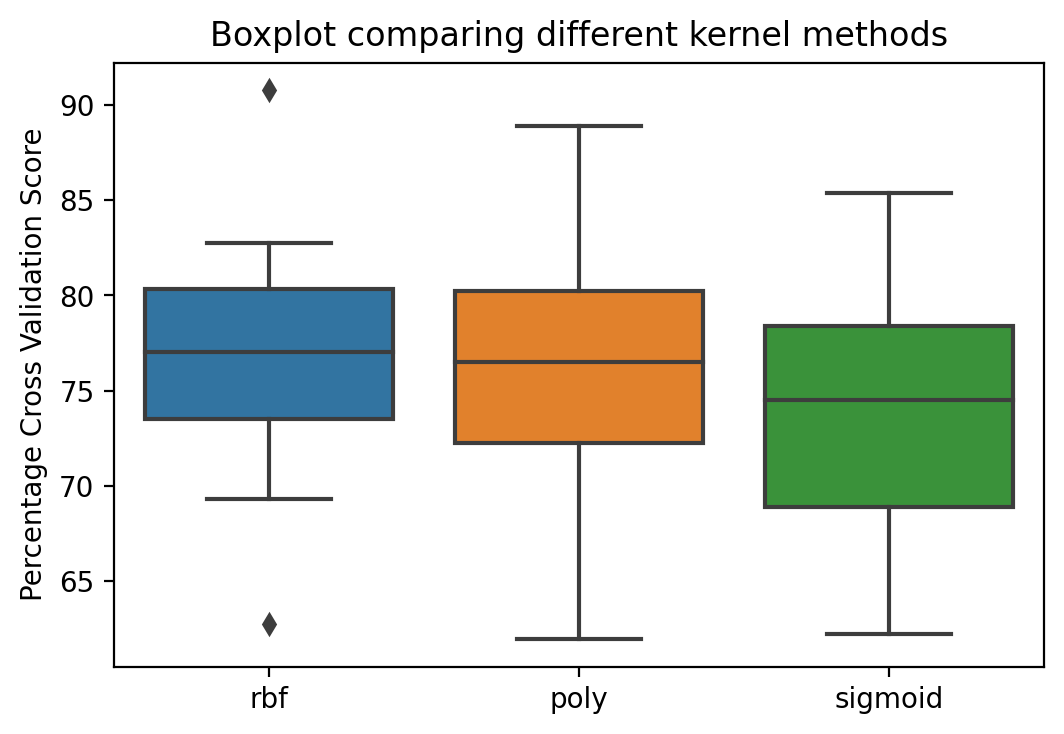

In [29]:
#@title graph 1: boxplots comparing kernels {form-width: "10%"}

dat = np.array([rbf_list, poly_list, sigmoid_list])
print(dat.shape)
df1 = pd.DataFrame(dat.T, columns=["rbf", "poly", "sigmoid"])
plt.figure(dpi=200)
p1 = sns.boxplot(data=df1)
plt.ylabel("Percentage Cross Validation Score")
plt.title("Boxplot comparing different kernel methods")
plt.show()

float64
        scores                     classifications  \
0    86.625000                          Go vs NoGo   
1    85.907539                          Go vs NoGo   
2    73.210526                          Go vs NoGo   
3    70.784314                          Go vs NoGo   
4    87.644444                          Go vs NoGo   
..         ...                                 ...   
97   80.017730  Correct response vs Wrong response   
98   79.126140  Correct response vs Wrong response   
99   78.679711  Correct response vs Wrong response   
100  79.571935  Correct response vs Wrong response   
101  79.928445  Correct response vs Wrong response   

                               method  
0    Separate models for each session  
1    Separate models for each session  
2    Separate models for each session  
3    Separate models for each session  
4    Separate models for each session  
..                                ...  
97      1 Model for combined sessions  
98      1 Model for com

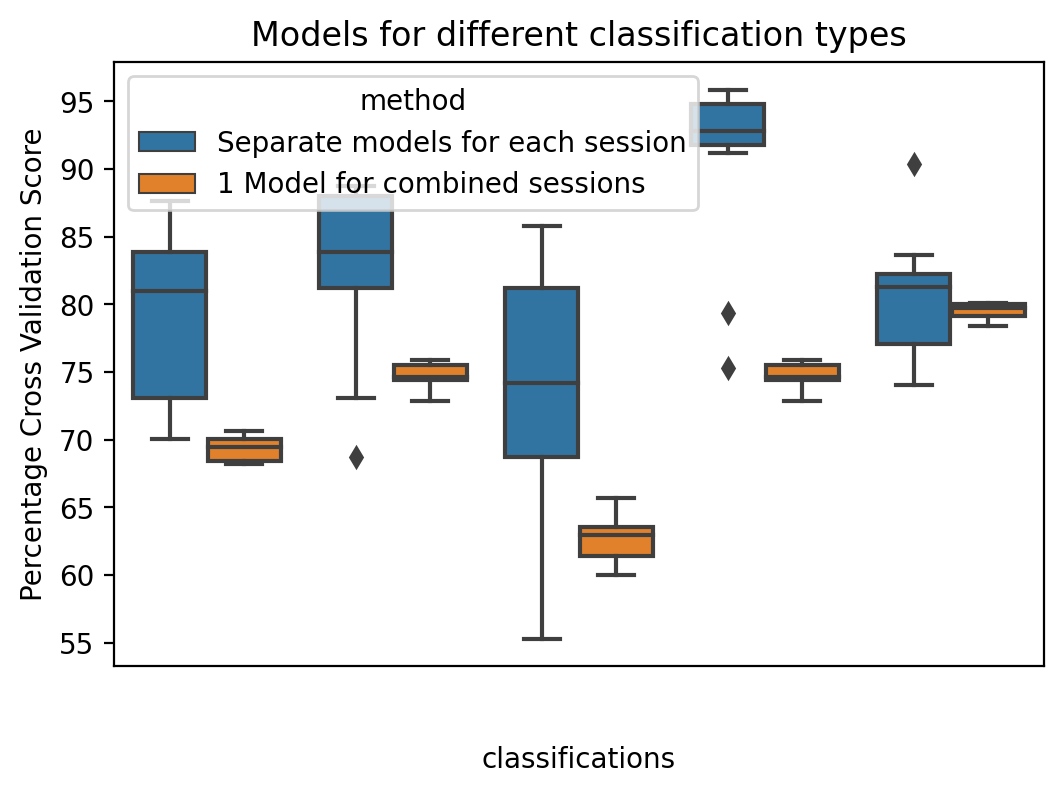

In [30]:
#@title graph 2 {form-width:"10%"}
h = np.repeat(None, 30)

g21 = np.array([86.62500000000001, 85.90753911806544, 73.21052631578948, 70.7843137254902, 87.64444444444443, 80.62279511533242, 80.97435897435898, 70.05120910384068, 81.89177489177489, 72.97132284921368, 81.83785822021117])
g22 = np.array([81.64923076923077, 88.14814814814815, 68.7037037037037, 88.74453781512607, 88.5965909090909, 86.21775898520083, 83.89417989417989, 82.58153846153846, 73.06535947712419, 80.78787878787878, 87.85517241379311])
g23 = np.array([72.47619047619048, 75.92727272727272, 55.27941176470588, 57.38461538461539, 85.73913043478261, 79.65151515151516, 72.5, 85.8051948051948])
g24 = np.array([93.55384615384615, 93.85185185185186, 75.33068783068782, 95.81344537815124, 95.83712121212122, 95.84989429175475, 92.42063492063492, 92.79384615384615, 79.36601307189542, 91.15151515151514, 92.71264367816092])
g25 = np.array([81.3076923076923, 90.37301587301589, 82.96559139784947, 77.05102040816327, 81.24418604651163, 77.01427815970386, 80.68571428571427, 74.02083333333334, 83.6153846153846, 81.55602536997885, 77.11613475177305])


g31=np.array([0.6831210191082802, 0.6823248407643312, 0.7062101910828025, 0.6839171974522293, 0.697452229299363, 0.7014331210191083, 0.7030254777070064, 0.6855095541401273, 0.6950636942675159, 0.6934713375796178])*100
g32=np.array([0.7436714237172953, 0.7448394495412844, 0.7413778457356439, 0.7574966021066938, 0.7586327726809378, 0.7448394495412844, 0.7287419300033979, 0.7551711688752973, 0.7482798165137614, 0.7551924057084607])*100
g33=np.array([0.6259566326530612, 0.6078337585034013, 0.6337159863945578, 0.6103847789115646, 0.6571534863945578, 0.6260097789115646, 0.6337691326530612, 0.6441326530612246, 0.6000212585034014, 0.636373299319728])*100
g34=np.array([0.7436714237172953, 0.7448394495412844, 0.7413778457356439, 0.7574966021066938, 0.7586327726809378, 0.7448394495412844, 0.7287419300033979, 0.7551711688752973, 0.7482798165137614, 0.7551924057084607])*100
g35=np.array([0.8010701621073961, 0.793040780141844, 0.7992907801418441, 0.8001773049645391, 0.7841248733535968, 0.8001773049645391, 0.7912613981762917, 0.7867971124620061, 0.7957193515704154, 0.7992844478216818])*100

classifications1 = np.concatenate((np.repeat("Go vs NoGo", g21.shape[0]), np.repeat("Go: Correct vs Go: Wrong vs Go: Missed", g22.shape[0]), np.repeat("NoGo: Correct vs NoGo: Wrong", g23.shape[0]), np.repeat("Go: Response Given vs  Go: Missed", g24.shape[0]), np.repeat("Correct response vs Wrong response", g25.shape[0])))
classifications2 = np.concatenate((np.repeat("Go vs NoGo", g31.shape[0]), np.repeat("Go: Correct vs Go: Wrong vs Go: Missed", g32.shape[0]), np.repeat("NoGo: Correct vs NoGo: Wrong", g33.shape[0]), np.repeat("Go: Response Given vs  Go: Missed", g34.shape[0]), np.repeat("Correct response vs Wrong response", g35.shape[0])))
classifications = np.concatenate((classifications1, classifications2))
g2 = np.concatenate((g21,g22,g23,g24,g25,g31,g32,g33,g34,g35))
method = np.concatenate((np.repeat("Separate models for each session", classifications1.shape[0]), np.repeat("1 Model for combined sessions", classifications2.shape[0])))
print(g2.dtype)
data2 = {"scores": g2,
        "classifications": classifications,
         "method":method}
df2 = pd.DataFrame(data2)
print(df2)
plt.figure(dpi=200)
p2 = sns.boxplot(x="classifications", y="scores",hue="method", data=df2)

# g2_data_33 = np.concatenate((np.array(g2_data_3).astype(float), np.zeros(30)))

# g2_data_1 = np.array(g2_data_1).astype('float32')
# g2_data_2 = np.array(g2_data_2).astype('float32')
# g2_data_4 = np.array(g2_data_4).astype('float32')
# g2_data_5 = np.array(g2_data_5).astype('float32')
# print(g2_data_33.shape)
# sns.boxplot(g2_data_4, orient="v")
# plt.show()
# g2 = np.stack((g2_data_1, g2_data_2, g2_data_33, g2_data_4, g2_data_5)).T
# print(g2.shape)

# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5)

# ax1.boxplot(x=None, data=g21)
# ax2.boxplot(data=g22)
# ax3.boxplot(data=g23)
# ax4.boxplot(data=g24)
# ax5.boxplot(data=g25)

plt.ylabel("Percentage Cross Validation Score")
plt.title("Models for different classification types")
plt.tick_params(axis='x', labelrotation=60, labelsize=-1, colors="white")
plt.show()

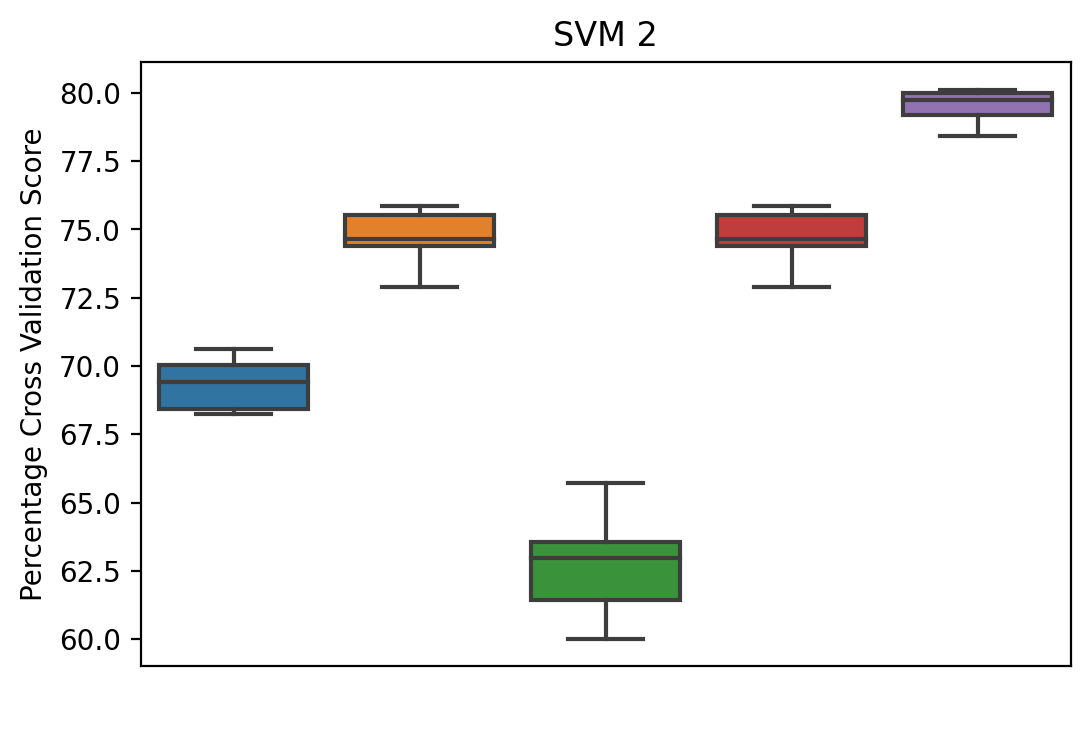

In [31]:
#@title graph3 {form-width: "10%"}

g31=np.array([0.6831210191082802, 0.6823248407643312, 0.7062101910828025, 0.6839171974522293, 0.697452229299363, 0.7014331210191083, 0.7030254777070064, 0.6855095541401273, 0.6950636942675159, 0.6934713375796178]) * 100
g32=np.array([0.7436714237172953, 0.7448394495412844, 0.7413778457356439, 0.7574966021066938, 0.7586327726809378, 0.7448394495412844, 0.7287419300033979, 0.7551711688752973, 0.7482798165137614, 0.7551924057084607])* 100
g33=np.array([0.6259566326530612, 0.6078337585034013, 0.6337159863945578, 0.6103847789115646, 0.6571534863945578, 0.6260097789115646, 0.6337691326530612, 0.6441326530612246, 0.6000212585034014, 0.636373299319728])* 100
g34=np.array([0.7436714237172953, 0.7448394495412844, 0.7413778457356439, 0.7574966021066938, 0.7586327726809378, 0.7448394495412844, 0.7287419300033979, 0.7551711688752973, 0.7482798165137614, 0.7551924057084607])* 100
g35=np.array([0.8010701621073961, 0.793040780141844, 0.7992907801418441, 0.8001773049645391, 0.7841248733535968, 0.8001773049645391, 0.7912613981762917, 0.7867971124620061, 0.7957193515704154, 0.7992844478216818])* 100

g3 = np.concatenate((g31,g32,g33,g34,g35)).T
data3 = {"scores": g3,
         "classifications":classifications2,
         }
df3 = pd.DataFrame(data=data3)
plt.figure(dpi=200)
p3 = sns.boxplot(x="classifications",y="scores", data=data3)
plt.ylabel("Percentage Cross Validation Score")
plt.title("SVM 2")
plt.tick_params(axis='x', labelrotation=60, labelsize=-1, colors="white")
plt.show()

[78.87700535 81.01604278 79.41176471 79.14438503 83.68983957 79.14438503
 81.55080214 83.15508021 80.48128342 79.14438503]


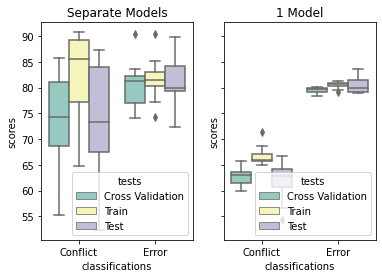

<Figure size 1200x800 with 0 Axes>

In [32]:
g4a = np.concatenate((g23, g25, g223, g225, g2223, g2225))

g223 = np.array(g223)
g225 = np.array(g225)
g2223 = np.array(g2223)
g2225 = np.array(g2225)
g333 = np.array(g333)*100
g335 = np.array(g335)*100
g3333 = np.array(g3333)*100
g3335 = np.array(g3335)*100
g4b = np.concatenate((g33, g35, g333, g335, g3333, g3335))
print(g3335)

classifications4a = np.concatenate((np.repeat("Conflict", g23.shape[0]), np.repeat("Error", g25.shape[0]), np.repeat("Conflict", g223.shape[0]), np.repeat("Error", g225.shape[0]),np.repeat("Conflict", g2223.shape[0]), np.repeat("Error", g2225.shape[0])))
classifications4b = np.concatenate((np.repeat("Conflict", g33.shape[0]), np.repeat("Error", g35.shape[0]),np.repeat("Conflict", g333.shape[0]), np.repeat("Error", g335.shape[0]),np.repeat("Conflict", g3333.shape[0]), np.repeat("Error", g3335.shape[0])))
trip4a = np.concatenate(( np.repeat("Cross Validation", g23.shape[0]+g25.shape[0]), np.repeat("Train", g223.shape[0]+g225.shape[0]), np.repeat("Test", g2223.shape[0]+g2225.shape[0]) ))
trip4b = np.concatenate(( np.repeat("Cross Validation", g33.shape[0]+g35.shape[0]), np.repeat("Train", g333.shape[0]+g335.shape[0]), np.repeat("Test", g3333.shape[0]+g3335.shape[0]) ))

data4a={"scores":g4a,
       "classifications":classifications4a,
        "tests":trip4a
       }
df4a = pd.DataFrame(data=data4a)

data4b = {"scores":g4b,
          "classifications":classifications4b,
          "tests":trip4b
          }
df4b = pd.DataFrame(data=data4b)

_, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plt.figure(dpi=200)
sns.boxplot(ax=ax1, x = "classifications",y="scores",hue="tests",orient="v", data=df4a, palette="Set3")
sns.boxplot(ax=ax2, x="classifications", y="scores", hue="tests",orient="v", data=df4b, palette="Set3")
ax1.set_title("Separate Models")
ax2.set_title("1 Model")

plt.show()

In [33]:
# from matplotlib.colors import ListedColormap
# cmap = ListedColormap(sns.color_palette('pastel'))
# plt.figure(dpi=200)
# session_number_of_neurons = [session['ACA_neurons'].shape[0] for session in sessions_with_ACA]
# session_rbf_svm_score = []
# plt.scatter(session_number_of_neurons,session_poly_svm_score,c=cmap.colors[0:len(session_poly_svm_score)])
# plt.title('Correlation Between Number of Neurons Per Session & SVM Accuracy')
# plt.xlabel('Number of neurons')
# plt.ylabel('Score')
# plt.show()